## Tabular Q-Learning/SARSA
This is a implementation of the continuous observation environment [MountainCar](https://gym.openai.com/envs/MountainCar-v0) in tabular form.
It was possible to make a tabular version by digitizing the observation space values using the functions [numpy.digitize](https://numpy.org/doc/1.18/reference/generated/numpy.digitize.html) and [numpy.linspace](https://numpy.org/doc/1.18/reference/generated/numpy.linspace.html).<br>
It's a TD algorithm with two options of control (optimization), Q-Learning and SARSA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

from torch.utils.tensorboard import SummaryWriter

In [2]:
env = gym.make("MountainCar-v0").env

action_space = env.action_space.n
print("Action space:", action_space)

Action space: 3


Both Q-learning and Sarsa are methods of TD control. The main difference is that Q-learning is off-policy while Sarsa is on-policy. <br> 
From David Silver's slide on [Model-Free Control](https://www.davidsilver.uk/wp-content/uploads/2020/03/control.pdf):
On-policy learning:
* "Learn on the job"
* Learn about policy $\pi$ from experience sampled from $\pi$

Off-policy learning:
* "Look over someone's sholder"
* Learn about policy $\pi$ from experience sampled from b

The difference is in the update of the new action value. Pgs 130 and 131 of the [Reinforcement Learning 2nd ed. book](http://incompleteideas.net/book/the-book-2nd.html):
#### Sarsa
$Q(S,A) \leftarrow Q(S,A) + \alpha[R+\lambda Q(S',A')-Q(S,A)]$

#### Q-learning
$Q(S,A) \leftarrow Q(S,A) + \alpha[R+\lambda max_aQ(S',a)-Q(S,A)]$

In [3]:
class Agent():
    def __init__(self, epsilon, position_min, position_max, speed_min, speed_max, alpha, gamma):
        
        self.q_table = {}
        self.epsilon = epsilon
        
        self.discount_factor = gamma
        self.alpha = alpha

        self.position_bins = np.linspace(position_min, position_max, 30)
        self.speed_bins = np.linspace(speed_min, speed_max, 30)

        # populate the q_table
        for pos in self.position_bins:
            for spd in self.speed_bins:
                self.q_table[(pos, spd)] = [0 for _ in range(action_space)]

    def get_state_digitized(self, state):
        ''' digitize state value, which is continuous '''
        pos_dig_i = np.digitize(state[0], self.position_bins)
        pos_dig = self.position_bins[pos_dig_i]

        speed_dig_i = np.digitize(state[1], self.speed_bins)
        speed_dig = self.speed_bins[speed_dig_i]
        return pos_dig, speed_dig

    def get_greedy_action(self, state):
        ''' get the table action with highest value given the state'''
        pos, spd = self.get_state_digitized(state)
        greedy_action = np.argmax(self.q_table[(pos, spd)])
        return greedy_action 

    def get_max_qvalue(self, state):
        pos, spd = self.get_state_digitized(state)
        max_qvalue = np.max(self.q_table[(pos, spd)])
        return max_qvalue 
    
    def get_qvalue(self, state, action):
        pos, spd = self.get_state_digitized(state)
        qvalue = self.q_table[(pos, spd)][action]
        return qvalue 

    def e_greedy_policy(self, state):
        ''' get the action based on the e-greedy-policy'''
        if np.random.rand() < self.epsilon:
            action = np.random.randint(action_space)
        else:
            action = self.get_greedy_action(state) 
        return action
    
    def td_control(self, state, action, new_state, reward, done, sarsa=False):
        ''' update the table with the new action-value that can be calculated using Q-Learning or SARSA''' 
        not_done = 1 - done
        
        if sarsa:
            target = reward + self.discount_factor*self.get_qvalue(new_state, action)
            q_value = self.get_qvalue(state, action)
            new_q_value = q_value + self.alpha*(target - q_value)*not_done
        else:
            q_target = reward + self.discount_factor*self.get_max_qvalue(new_state)
            q_value = self.get_qvalue(state, action)
            new_q_value = q_value + self.alpha*(q_target - q_value)*not_done

        # update table
        self.set_qvalue(state, action, new_q_value)

            
    def set_qvalue(self, state, action, value):
        ''' set action-value in the table'''
        pos, spd = self.get_state_digitized(state)
        self.q_table[(pos, spd)][action] = value

In [4]:
# epsilon for the epsilon-greedy policy
epsilon_init = 0.8
epsilon_end = 0.1

alpha = 0.5 # learning rate
discount_factor = 0.99

# two agents were created for the sake of testing control with Q-learning and SARSA
agent1 = Agent(epsilon_init, env.min_position, env.max_position, -env.max_speed, env.max_speed, alpha=alpha, gamma=discount_factor)
agent2 = Agent(epsilon_init, env.min_position, env.max_position, -env.max_speed, env.max_speed, alpha=alpha, gamma=discount_factor)

In [5]:
# writter for tensorboard
writer = SummaryWriter()
# to see the board run on terminal the following command:
# tensorboard --logdir=runs

In [6]:
def train(agent, n_epochs=200, sarsa=False):
    if sarsa:
        agent_tag = 'SARSA'
    else:
        agent_tag = 'Q-Learning'
    epsilon_discount = (epsilon_init - epsilon_end)/n_epochs
    
    rewards_history = []
    for epoch in range(1, n_epochs+1):

        state = env.reset()
        done = False
        reward_sum = 0

        while not done:
            action = agent.e_greedy_policy(state)
            new_state, reward, done, info = env.step(action)

            reward_sum += reward
            
            agent.td_control(state, action, new_state, reward, done, sarsa=sarsa)
           
            state = new_state
        rewards_history.append(reward_sum)
        writer.add_scalar(f'{agent_tag}/Reward/Train', reward_sum, epoch)
        if epoch % 50 == 0:
            print("Epoch={} \t reward={}\t epsilon={:.4f}".format(epoch, reward_sum, agent.epsilon))
        
        agent.epsilon -= epsilon_discount
    return rewards_history

In [7]:
rewards = train(agent1, n_epochs=2000, sarsa=False)

Epoch=50 	 reward=-736.0	 epsilon=0.7829
Epoch=100 	 reward=-1053.0	 epsilon=0.7654
Epoch=150 	 reward=-928.0	 epsilon=0.7479
Epoch=200 	 reward=-1528.0	 epsilon=0.7304
Epoch=250 	 reward=-828.0	 epsilon=0.7129
Epoch=300 	 reward=-1316.0	 epsilon=0.6954
Epoch=350 	 reward=-3004.0	 epsilon=0.6779
Epoch=400 	 reward=-630.0	 epsilon=0.6604
Epoch=450 	 reward=-924.0	 epsilon=0.6429
Epoch=500 	 reward=-904.0	 epsilon=0.6254
Epoch=550 	 reward=-635.0	 epsilon=0.6079
Epoch=600 	 reward=-905.0	 epsilon=0.5904
Epoch=650 	 reward=-552.0	 epsilon=0.5729
Epoch=700 	 reward=-731.0	 epsilon=0.5554
Epoch=750 	 reward=-430.0	 epsilon=0.5379
Epoch=800 	 reward=-478.0	 epsilon=0.5204
Epoch=850 	 reward=-601.0	 epsilon=0.5029
Epoch=900 	 reward=-598.0	 epsilon=0.4854
Epoch=950 	 reward=-667.0	 epsilon=0.4679
Epoch=1000 	 reward=-371.0	 epsilon=0.4504
Epoch=1050 	 reward=-545.0	 epsilon=0.4329
Epoch=1100 	 reward=-312.0	 epsilon=0.4154
Epoch=1150 	 reward=-393.0	 epsilon=0.3979
Epoch=1200 	 reward=-654.0	

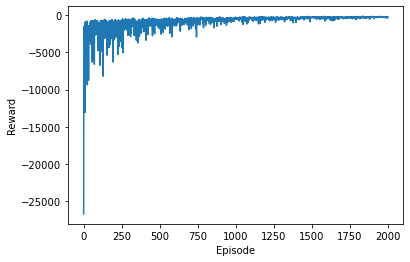

In [8]:
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [9]:
rewards = train(agent2, n_epochs=2000, sarsa=True)

Epoch=50 	 reward=-932.0	 epsilon=0.7829
Epoch=100 	 reward=-921.0	 epsilon=0.7654
Epoch=150 	 reward=-752.0	 epsilon=0.7479
Epoch=200 	 reward=-666.0	 epsilon=0.7304
Epoch=250 	 reward=-546.0	 epsilon=0.7129
Epoch=300 	 reward=-626.0	 epsilon=0.6954
Epoch=350 	 reward=-616.0	 epsilon=0.6779
Epoch=400 	 reward=-379.0	 epsilon=0.6604
Epoch=450 	 reward=-609.0	 epsilon=0.6429
Epoch=500 	 reward=-443.0	 epsilon=0.6254
Epoch=550 	 reward=-532.0	 epsilon=0.6079
Epoch=600 	 reward=-295.0	 epsilon=0.5904
Epoch=650 	 reward=-541.0	 epsilon=0.5729
Epoch=700 	 reward=-526.0	 epsilon=0.5554
Epoch=750 	 reward=-680.0	 epsilon=0.5379
Epoch=800 	 reward=-457.0	 epsilon=0.5204
Epoch=850 	 reward=-773.0	 epsilon=0.5029
Epoch=900 	 reward=-353.0	 epsilon=0.4854
Epoch=950 	 reward=-581.0	 epsilon=0.4679
Epoch=1000 	 reward=-558.0	 epsilon=0.4504
Epoch=1050 	 reward=-596.0	 epsilon=0.4329
Epoch=1100 	 reward=-281.0	 epsilon=0.4154
Epoch=1150 	 reward=-497.0	 epsilon=0.3979
Epoch=1200 	 reward=-509.0	 eps

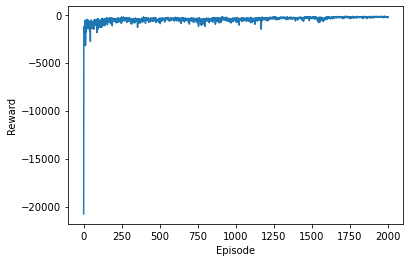

In [10]:
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [11]:
from time import sleep

def play_game(env, agent):
    for i in range(3):
        state = env.reset()
        done = False
        reward_sum = 0
        while not done:
            env.render()
            action = agent.get_greedy_action(state)

            state, reward, done, _ = env.step(action)
            reward_sum += reward

            sleep(0.01)
        print("Episode finished. Reward={:.4f}".format(reward_sum))

In [12]:
play_game(env, agent=agent1)

Episode finished. Reward=-331.0000
Episode finished. Reward=-332.0000
Episode finished. Reward=-328.0000


In [13]:
# play some games with the trained agent
from gym import wrappers
dir_videos = "./tabqlearningsarsa-results-cartpole"

env_monitor = wrappers.Monitor(env, directory=dir_videos, force=True)

for _ in range(3):
    play_game(env_monitor, agent1) 
env_monitor.close()

Episode finished. Reward=-300.0000
Episode finished. Reward=-257.0000
Episode finished. Reward=-221.0000
Episode finished. Reward=-269.0000
Episode finished. Reward=-232.0000
Episode finished. Reward=-305.0000
Episode finished. Reward=-306.0000
Episode finished. Reward=-255.0000
Episode finished. Reward=-305.0000
